#                                   Multinomial Naive Bayes Model

## Importing Modules

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#for sklearn model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Dataset into Dataframe

In [2]:
df= pd.read_csv("/home/shakeer/Downloads/data.csv")

## Exploring Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [4]:
df.columns

Index(['Sentence', 'Sentiment'], dtype='object')

In [5]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,"Operating loss totalled EUR 0.9 mn , down from...",neutral
freq,2,3130


## Visualizing the Sentence and Sentiment Data

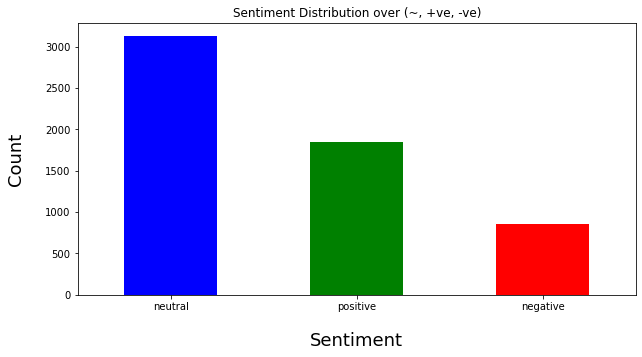

In [6]:
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(10,5))
sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'])  #line', 'bar', 'barh', 'kde', 'density', 'area', 'hist', 'box', 'pie', 'scatter', 'hexbin
plt.title('Sentiment Distribution over (~, +ve, -ve)')
plt.xlabel('Sentiment',labelpad=20, fontsize=18)
plt.ylabel('Count',labelpad=20, fontsize=18)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

In [7]:
round((df.isnull().sum()/df.shape[0])*100) #check null values / missing values

Sentence     0.0
Sentiment    0.0
dtype: float64

In [8]:
print("No of Rows in Original Dataset: ",len(df)) 

No of Rows in Original Dataset:  5842


## Removal of duplicate rows

In [9]:
duplicate_rows = df[df.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows)
#print(df['Sentiment'][234])

Duplicate Rows:
                                               Sentence Sentiment
1825  Proha Plc ( Euronext :7327 ) announced today (...   neutral
1859  SSH Communications Security Corporation is hea...   neutral
2672  Ahlstrom 's share is quoted on the NASDAQ OMX ...   neutral
3272  The company serves customers in various indust...   neutral
3986  The issuer is solely responsible for the conte...   neutral
5342  The report profiles 614 companies including ma...   neutral


In [10]:
df.drop_duplicates(inplace=True)

In [11]:
print("No of Rows after dropping duplicate rows : ",len(df))

No of Rows after dropping duplicate rows :  5836


In [12]:
sentiment = {
    'negative':0,
    'neutral' :1,
    'positive':2
}

In [13]:
df['Sentiment'] = df['Sentiment'].apply(lambda x:sentiment[x])
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",2
3,According to the Finnish-Russian Chamber of Co...,1
4,The Swedish buyout firm has sold its remaining...,1


## Splitting Train and Test data from Dataset

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [15]:
X_train,X_test,y_train,y_test = train_test_split(df['Sentence'],df['Sentiment'],test_size =0.2,stratify=df['Sentiment'],random_state=42)
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((4668,), (1168,), (4668,), (1168,))

## Setting Vocabulary from Training Set

In [16]:
vocab = set()
for text in X_train:
    vocab.update(text.split())
vocab = list(vocab)
#print(vocab)

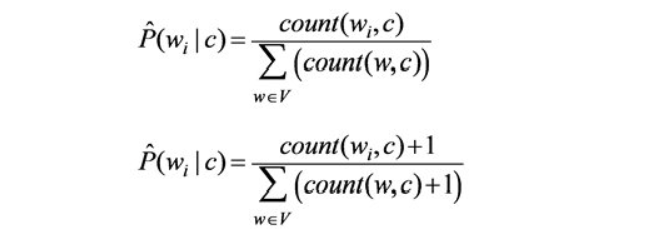

## Multinomial Naive Bayes Model

In [17]:
class NaiveBayesClassifier:
    def __init__(self, classes):
        self.classes = classes
        self.class_priors = {}
        self.word_counts = {}
        self.word_probs = {}
        self.vocab = []

    def preprocess_text(self, text): # Lower text and remove stopwords
        stop_words = set(stopwords.words('english'))
        ps = PorterStemmer()
        words = nltk.word_tokenize(text.lower())
        words = [ps.stem(word) for word in words if word.isalpha() and word not in stop_words]
        return words

    def fit(self, X, y, vocab):
        self.vocab = vocab
        vocab_size = len(vocab)

        self.word_counts = {c: np.zeros(vocab_size) for c in self.classes} #initialize to 0's
        self.word_probs = {c: np.zeros(vocab_size) for c in self.classes}  #initialize to 0's

        for c in self.classes:
            total_count = np.sum(y == c)
            self.class_priors[c] = total_count / len(y) # setting class priors P(C'k)
            class_texts = X[y == c]
            class_words = []
            for text in class_texts:
                class_words.extend(self.preprocess_text(text))
            for word in class_words:
                if word in vocab:
                    self.word_counts[c][vocab.index(word)] += 1

            total_words = np.sum(self.word_counts[c])
            
            self.word_probs[c] = (self.word_counts[c] + 1) / (total_words + (vocab_size)) # Laplace Smoothing - 0 p issue

    def predict_proba(self, X):
        probas = []
        for text in X:
            words = self.preprocess_text(text)
            scores = {}
            for c in self.classes:
                log_prob = np.log(self.class_priors[c])
                for word in words:
                    if word in self.vocab:
                        word_idx = self.vocab.index(word)
                        log_prob += np.log(self.word_probs[c][word_idx])
                scores[c] = log_prob
            exp_scores = {c: np.exp(score) for c, score in scores.items()}
            sum_exp_scores = sum(exp_scores.values())
            probas.append({c: exp_scores[c] / sum_exp_scores for c in self.classes})
        return probas

# Initialize model and train the classifier
model = NaiveBayesClassifier(classes=[0,1,2])
model.fit(X_train, y_train, vocab)

In [18]:
#new_text = "Effective portfolio diversification can mitigate risk and enhance long-term returns"
new_text = input("Enter Some Text : ");
probas = model.predict_proba([new_text])[0]
print(f'Predicted Probabilities for "{new_text}": {probas}')
print(probas ,'\n')
if(probas[0]>probas[1] and probas[0]>probas[2]):
    print("Negative : 0")
    print(probas[0])
elif(probas[1]>probas[2]):
    print("Neutral : 1")
    print(probas[1])
else:
    print("Positive : 2")
    print(probas[2])
print(max(probas.values()))

Enter Some Text : investing more gives more return
Predicted Probabilities for "investing more gives more return": {0: 0.0033410061999481857, 1: 0.8726975583002309, 2: 0.12396143549982093}
{0: 0.0033410061999481857, 1: 0.8726975583002309, 2: 0.12396143549982093} 

Neutral : 1
0.8726975583002309
0.8726975583002309


## Creating using Sklearn Model 

In [19]:
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

In [20]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Accuracy:0.6532534246575342
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.02      0.05       172
           1       0.63      0.97      0.77       625
           2       0.74      0.40      0.52       371

    accuracy                           0.65      1168
   macro avg       0.79      0.47      0.45      1168
weighted avg       0.72      0.65      0.58      1168



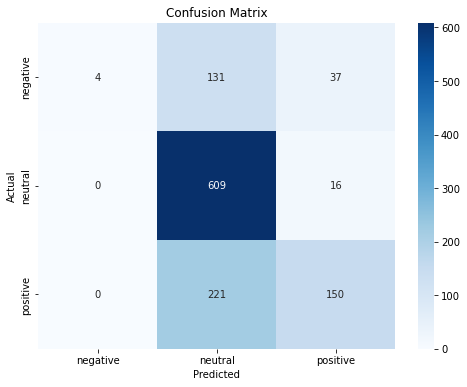

In [21]:
# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:{accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment.keys(), yticklabels=sentiment.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()